<a href="https://colab.research.google.com/github/Eliandry/Neural-networks/blob/main/guessEmotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
from keras.models import Sequential
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, GlobalAveragePooling2D,MaxPooling2D,BatchNormalization
from google.colab import files
from PIL import Image
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
from keras.losses import categorical_crossentropy
from keras.applications import vgg19
from sklearn.utils import shuffle
import cv2
import pandas as pd
import warnings
from keras.initializers import  RandomNormal
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, TensorBoard

In [53]:
warnings.filterwarnings("ignore")

data = pd.read_csv('./fer2013.csv')
width, height = 48, 48
datapoints = data['pixels'].tolist()

    # получаем все свойства для дальнейшего обучения
X = []
for xseq in datapoints:
    xx = [int(xp) for xp in xseq.split(' ')]
    xx = np.asarray(xx).reshape(width, height)
    X.append(xx.astype('float32'))

X = np.asarray(X)
X = np.expand_dims(X, -1)

    # получем лэйблы для обучения
y = pd.get_dummies(data['emotion']).values

In [54]:
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.7, random_state=41)

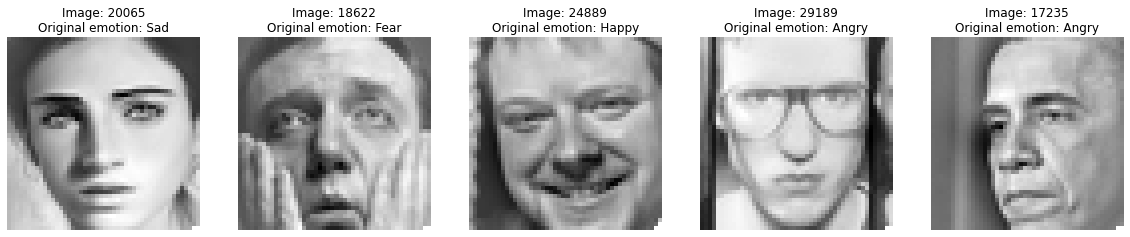

In [42]:
def show_random(imgs, emotion_nms_org = None, emotion_nms_pred = None, random = True, indices = None):
    if random == True:
        indices = np.random.randint(0, len(imgs), size = 5)
    else:
        indices = np.random.choice(list(indices), size = 5, replace = False)
    plt.figure(figsize=(20, 14)) 
    for index, number in enumerate(indices):
        plt.subplot(3,5, index + 1)
        if (isinstance(emotion_nms_org, type(None)) & isinstance(emotion_nms_pred, type(None))):
            plt.title('Image: ' + str(indices[index]))           
        elif (isinstance(emotion_nms_org, type(None)) & ~isinstance(emotion_nms_pred, type(None))):
            plt.title('Image: ' + str(indices[index]) + '\n' + 'Predicted emotion:' + emotion_nms_pred[indices[index]])
        elif (~isinstance(emotion_nms_org, type(None)) & isinstance(emotion_nms_pred, type(None))):
             plt.title('Image: ' + str(indices[index]) + '\n' + 'Original emotion: ' + emotion_nms_org[indices[index]])           
        else:
            plt.title('Image: ' + str(indices[index]) + '\n' + 'Original emotion: ' + emotion_nms_org[indices[index]] + 
                      '\n' + 'Predicted emotion:' + emotion_nms_pred[indices[index]])
        show_image = imgs[number].reshape(48,48)
        plt.axis('off')
        plt.imshow(show_image, cmap='gray')
        

show_random(images, emotion_nms_org= data['emotion_name'])

In [43]:
images = images.reshape(images.shape[0], 48, 48, 1)
images = images.astype('float32')

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle = False)

In [58]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 20
width, height = 48, 48

In [55]:
model = Sequential()


model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(48,48,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(48,48,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))

# 3rd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))
          
# 5th convolution layer
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))

# 7th convolution layer
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.1))


model.add(Flatten())
# Fully connected layers
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(7, activation='softmax'))

In [56]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [60]:
model.fit(np.array(X_train), np.array(y_train),
          batch_size=64,
          epochs=3,
          verbose=1,
          validation_data=(np.array(X_val), np.array(y_val)),
          shuffle=True)

Epoch 1/3
51/51 [==============================] - 157s 3s/step - loss: 1.7851 - accuracy: 0.2632 - val_loss: 1.7884 - val_accuracy: 0.2733
Epoch 2/3
51/51 [==============================] - 158s 3s/step - loss: 1.7617 - accuracy: 0.2719 - val_loss: 1.8489 - val_accuracy: 0.2664
Epoch 3/3
51/51 [==============================] - 158s 3s/step - loss: 1.7590 - accuracy: 0.2673 - val_loss: 1.8360 - val_accuracy: 0.2756


In [69]:
imgs = Image.open(f'/content/1.jpg').convert('L')
imgs=np.array(imgs)
imgs=vgg19.preprocess_input(np.expand_dims(imgs,axis=0))
imgs.shape=(imgs.shape[0],48,48,1)
print(imgs.shape)
model.predict(imgs)


(1, 48, 48, 1)


array([[2.6387305e-04, 0.0000000e+00, 4.5310371e-16, 1.0652715e-19,
        9.9973613e-01, 7.6975297e-17, 2.9043001e-14]], dtype=float32)

https://github.com/elzawie/FER2013/blob/master/Best_model.ipynb